# Model predykcyjny plonów pszenicy ozimej z uwzględnieniem klastrów regionalnych

W tym notebooku rozwijamy badania zapoczątkowane w analizie eksploracyjnej (Notebook 02), koncentrując się na budowie, optymalizacji i interpretacji modelu predykcyjnego plonów pszenicy. Model wykorzystuje odkryte wcześniej wzorce regionalne w formie klastrów oraz cechy agronomiczne i meteorologiczne.

---

## Podsumowanie Notebooka 02

### Kluczowe ustalenia z analizy województw

**Klasteryzacja finansowa**
Przeprowadzona analiza klasteryzacji danych finansowych pozwoliła na wyodrębnienie trzech wyraźnych profili województw:

- **Klaster 0:** Województwa o wysokim zysku brutto (~3443 zł/ha), ale niższej efektywności nawożenia. Charakteryzują się wysokimi kosztami nawozów (średnio 32-34 zł/ha), szczególnie fosforowych i potasowych.
  _Przykłady: dolnośląskie, opolskie, wielkopolskie._

- **Klaster 1:** Zrównoważony profil z dobrym stosunkiem zysku (3409 zł/ha) do efektywności. Średnie koszty nawożenia przy dobrej efektywności składników.
  _Przykłady: pomorskie, zachodniopomorskie, śląskie._

- **Klaster 2:** Najwyższa efektywność nawozowa przy najniższych kosztach nawożenia, ale jednocześnie najniższy zysk brutto (2867 zł/ha).
  _Przykłady: lubuskie, małopolskie, warmińsko-mazurskie._

---

**Klasteryzacja pogodowa**
Równolegle zidentyfikowano trzy odrębne regiony pogodowe:

- **Klaster 0:** Chłodniejsze regiony (średnia temperatura 9.67°C) z umiarkowanymi opadami i wysoką liczbą dni mroźnych (18.2).
  _Przykłady: kujawsko-pomorskie, pomorskie, warmińsko-mazurskie._

- **Klaster 1:** Cieplejsze obszary (10.52°C) o niższych opadach i najmniejszej liczbie dni mroźnych (10.45).
  _Przykłady: dolnośląskie, lubuskie, wielkopolskie._

- **Klaster 2:** Regiony o najwyższej sumie opadów (785 mm) i pośredniej liczbie dni mroźnych.
  _Przykłady: małopolskie, opolskie, śląskie._

---

**Analiza wariancji (ANOVA)**
Analiza ANOVA potwierdziła istotność statystyczną różnic między klastrami:

- **Klastry finansowe:** Potwierdzone istotne różnice (p < 0.05) dla efektywności nawożenia wszystkimi składnikami (N, P, K) oraz kosztów nawożenia P i K. Brak istotnych różnic w zysku brutto (p = 0.1111).
- **Klastry pogodowe:** Wszystkie zmienne meteorologiczne wykazują istotne różnice między klastrami (p < 0.05).

---

## Zakres Notebooka 03

### 1. Budowa modelu predykcyjnego
   - Integracja klastrów jako zmiennych kategorycznych
   - Wykorzystanie Random Forest jako głównego algorytmu modelowania
   - Analiza ważności cech dla lepszego zrozumienia czynników kształtujących plony

## 2. Interpretacja wyników modelu
   - Wykresy zależności częściowych pokazujące relacje między zmiennymi
   - Symulacje plonów dla różnych warunków wzrostu
   - Optymalizacja nawożenia dla różnych regionów pogodowych

## 3. Rekomendacje agronomiczne
   - Analiza optymalnych dawek nawozów dla maksymalizacji plonów
   - Symulacje efektywności ekonomicznej dla różnych strategii nawożenia
   - Rekomendacje dostosowane do charakterystyki klastrów regionów

## 4. Wyzwania i dalsze kierunki badań
   - Ograniczenia wynikające z rozmiaru próby (10 województw)
   - Potencjał dla analiz czasowych i prognozowania trendów
   - Możliwości integracji z systemami wspomagania decyzji dla rolnictwa

---

Wyniki z modelu predykcyjnego pomogą lepiej zrozumieć, jak dostosować praktyki agronomiczne do warunków regionalnych i pogodowych, aby osiągnąć optymalne plony i efektywność ekonomiczną w uprawie pszenicy ozimej.


### 3.1. Model predykcyjny plonów pszenicy z uwzględnieniem klastrów

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
from sklearn.inspection import PartialDependenceDisplay
from scipy.optimize import minimize

# Ścieżki dostępu
SCIEZKA_DANYCH = Path("../data")
SCIEZKA_PROCESSED = SCIEZKA_DANYCH / "processed"
SCIEZKA_MODELI = Path("../models")
SCIEZKA_WYKRESOW = Path("../reports/visualizations")

### 3.2. Integracja danych z klasteryzacją

In [2]:
# Funkcja standaryzacji nazw z Notebooka 02
def standaryzuj_nazwe_wojewodztwa(nazwa):
    zamienniki = {'ą': 'a', 'ć': 'c', 'ę': 'e', 'ł': 'l', 'ń': 'n',
                  'ó': 'o', 'ś': 's', 'ź': 'z', 'ż': 'z', ' ': ''}
    for znak, zamiennik in zamienniki.items():
        nazwa = nazwa.lower().replace(znak, zamiennik)
    return nazwa.upper().replace('-', '')


# Wczytaj i przygotuj dane
df = pd.read_csv(SCIEZKA_PROCESSED / "panel_agroekonomiczny.csv")
df_klastry = pd.read_csv(SCIEZKA_PROCESSED / "dane_z_klastrami.csv")

# Standaryzacja nazw w obu zbiorach
df['wojewodztwo_std'] = df['wojewodztwo'].apply(standaryzuj_nazwe_wojewodztwa)
df_klastry['wojewodztwo_std'] = df_klastry['wojewodztwo_std'].apply(standaryzuj_nazwe_wojewodztwa)

# Scalanie danych
df = df.merge(
    df_klastry[['wojewodztwo_std', 'Klaster_Finansowy', 'Klaster_Pogodowy']],
    on='wojewodztwo_std',
    how='left'
)

### 3.3. Przygotowanie cech i zmiennej celu

In [3]:
features = [
    'Nawożenie N [kg/ha]',
    'Nawożenie P [kg/ha]',
    'Nawożenie K [kg/ha]',
    'Średnia temperatura [°C]',
    'Suma opadów [mm]',
    'Klaster_Finansowy',
    'Klaster_Pogodowy'
]

# Usuń rekordy z brakującymi klastrami i wartościami NaN
df_clean = df.dropna(subset=features + ['Plon [dt/ha]'])

X = df_clean[features]
y = df_clean['Plon [dt/ha]']

### 3.4. Podział danych i trenowanie modelu

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=2,
    random_state=42
)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=2, random_state=42)

### 3.5. Ewaluacja modelu

In [5]:
y_pred = model.predict(X_test)

print("Metryki oceny modelu:")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f} dt/ha")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f} dt/ha")
print(f"R²: {r2_score(y_test, y_pred):.2f}")


Metryki oceny modelu:
MAE: 4.39 dt/ha
RMSE: 5.98 dt/ha
R²: 0.43


C:\Users\brzos\Uczenie Maszynowe\Przenica_Ozima_ML\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### 3.6. Analiza ważności cech

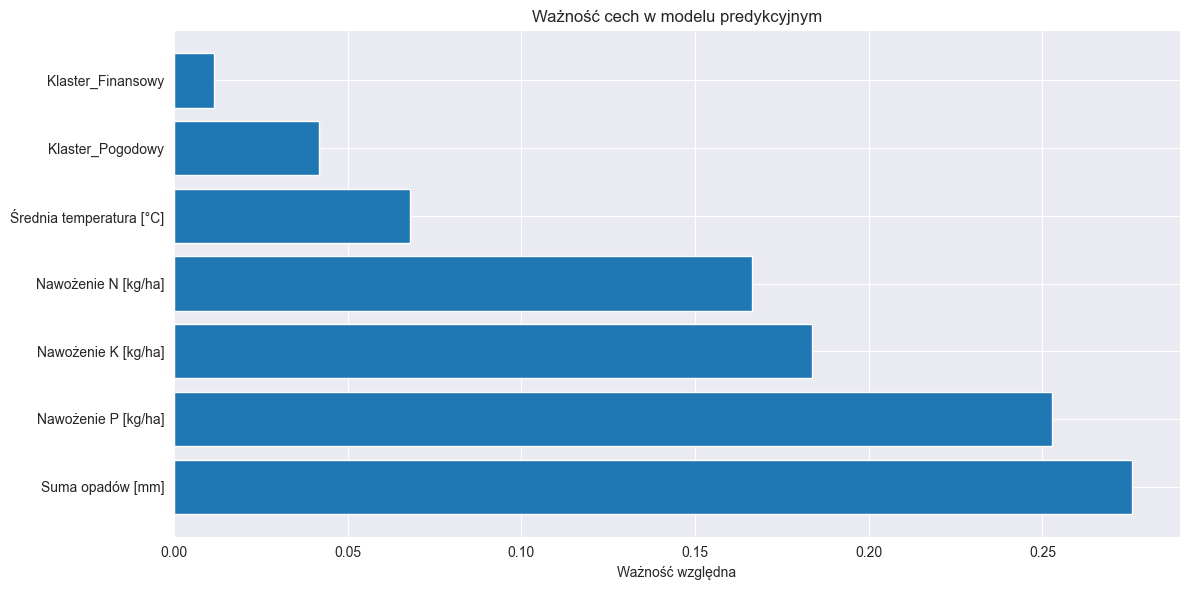

In [6]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Ważność cech w modelu predykcyjnym")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Ważność względna")
plt.tight_layout()
plt.savefig(SCIEZKA_WYKRESOW / "istotnosc_parametru.png", dpi=300, bbox_inches="tight")
plt.show()


### 3.7. Zapis modelu

In [7]:
SCIEZKA_MODELI.mkdir(parents=True, exist_ok=True)
joblib.dump(model, SCIEZKA_MODELI / "rf_model_plonow.pkl")
print(f"Model zapisano w: {SCIEZKA_MODELI / 'rf_model_plonow.pkl'}")

Model zapisano w: ..\models\rf_model_plonow.pkl


### 3.8 Szczegółowa analiza błędów modelu

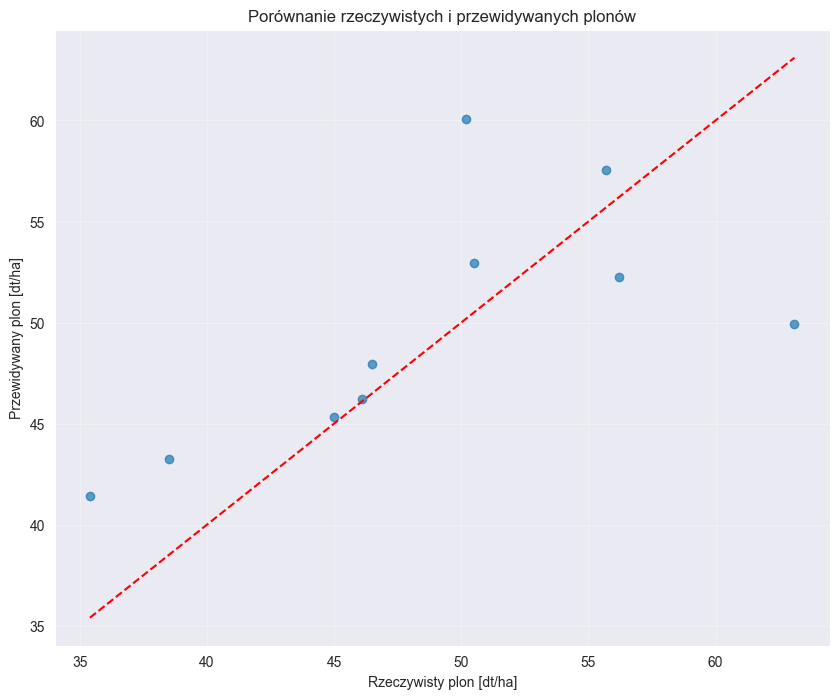

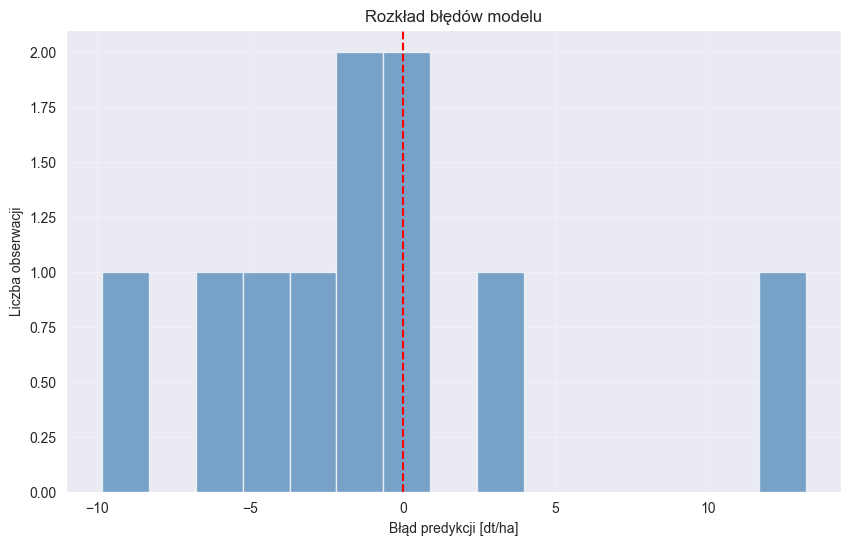

In [8]:
# Wizualizacja rzeczywistych vs przewidywanych wartości
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Rzeczywisty plon [dt/ha]')
plt.ylabel('Przewidywany plon [dt/ha]')
plt.title('Porównanie rzeczywistych i przewidywanych plonów')
plt.grid(True, alpha=0.3)
plt.savefig(SCIEZKA_WYKRESOW / "predykcje_vs_rzeczywiste.png", dpi=300)
plt.show()

# Histogram błędów predykcji
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=15, alpha=0.7, color='steelblue')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Błąd predykcji [dt/ha]')
plt.ylabel('Liczba obserwacji')
plt.title('Rozkład błędów modelu')
plt.grid(True, alpha=0.3)
plt.savefig(SCIEZKA_WYKRESOW / "histogram_bledow.png", dpi=300)
plt.show()

### 3.9 Analiza zależności częściowych (Partial Dependence Plots)

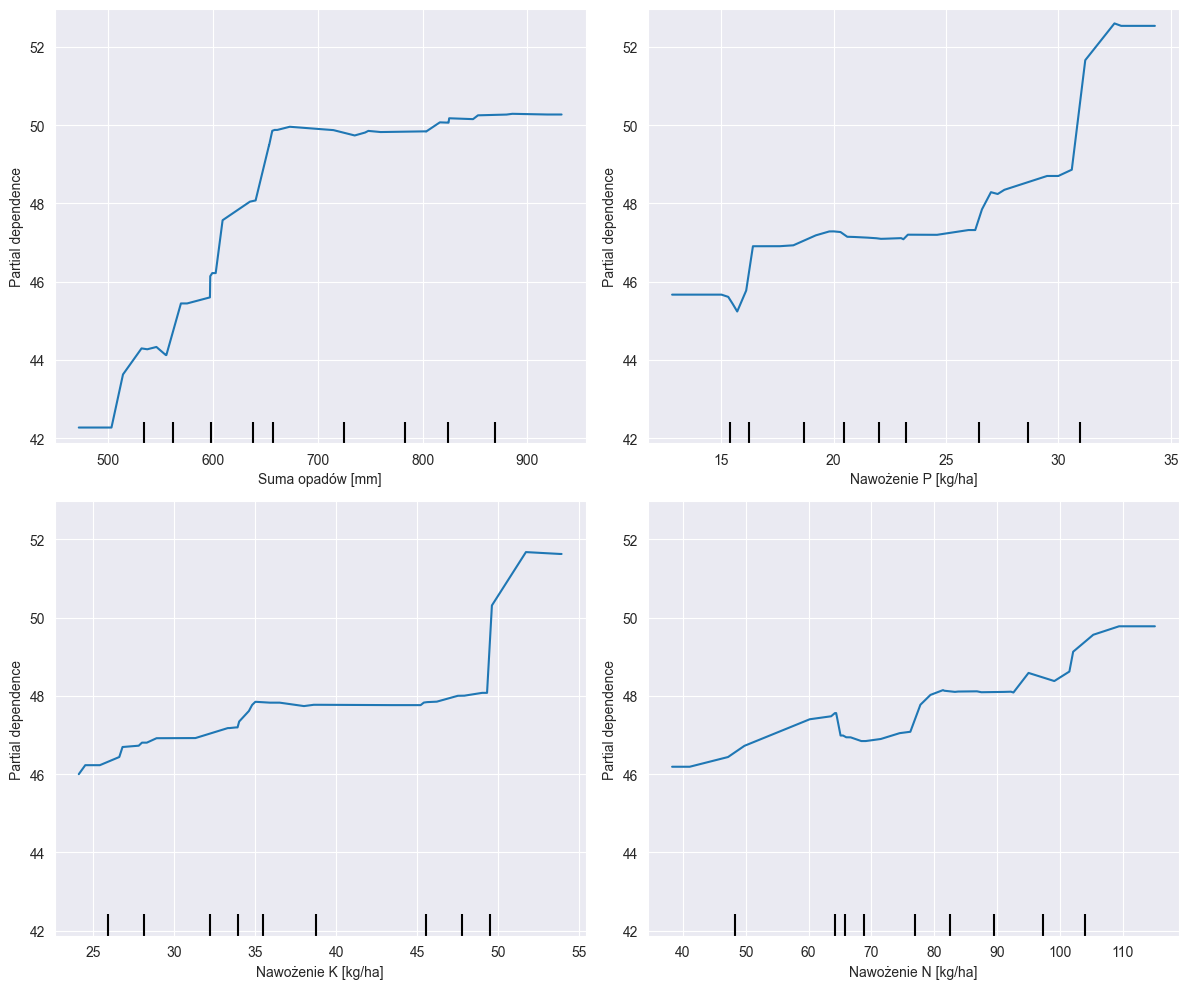

In [9]:
# Wybór najważniejszych zmiennych
top_features = [features[i] for i in indices[:4]]  # 4 najważniejsze cechy

# Wygenerowanie wykresów zależności częściowych
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
display = PartialDependenceDisplay.from_estimator(
    model, X_train, features=top_features,
    ax=ax.flatten(), n_jobs=2
)
plt.tight_layout()
plt.savefig(SCIEZKA_WYKRESOW / "zaleznosci_czesciowe.png", dpi=300)
plt.show()

### 3.10. Symulacja rekomendacji nawozowych

In [10]:
# Symulacja optymalnego nawożenia przy różnych warunkach pogodowych
def symuluj_plon(model, nawozenie_n, nawozenie_p, nawozenie_k, opady, temp, klaster_fin, klaster_pog):

    # Tworzymy DataFrame z nazwami kolumn - eliminuje warning
    features = ['Nawożenie N [kg/ha]', 'Nawożenie P [kg/ha]', 'Nawożenie K [kg/ha]',
                'Średnia temperatura [°C]', 'Suma opadów [mm]',
                'Klaster_Finansowy', 'Klaster_Pogodowy']

    X_sim = pd.DataFrame([[nawozenie_n, nawozenie_p, nawozenie_k, temp, opady, klaster_fin, klaster_pog]],
                        columns=features)
    return model.predict(X_sim)[0]

# Tabela rekomendacji z bardziej zróżnicowanymi parametrami
print("Rekomendacje nawozowe dla różnych warunków:")
print("=" * 80)
print(f"{'Warunki':<15} {'Opady':<8} {'Temp':<6} {'N [kg/ha]':<8} {'P [kg/ha]':<8} {'K [kg/ha]':<8} {'Plon [dt/ha]':<12}")
print("-" * 80)

# Symulacja dla zróżnicowanych warunków - większe kontrasty
warunki = [
    ("Korzystne", 800, 11.0, 105, 40, 50, 0, 1),  # Więcej opadów, wyższe nawożenie
    ("Przeciętne", 650, 9.5, 90, 30, 40, 1, 0),   # Parametry standardowe
    ("Niekorzystne", 450, 8.5, 70, 25, 35, 2, 2)  # Susza, niższe nawożenie
]

for nazwa, opady, temp, n, p, k, fin, pog in warunki:
    plon = symuluj_plon(model, n, p, k, temp, opady, fin, pog)
    print(f"{nazwa:<15} {opady:<8.0f} {temp:<6.1f} {n:<8.0f} {p:<8.0f} {k:<8.0f} {plon:<12.1f}")

Rekomendacje nawozowe dla różnych warunków:
Warunki         Opady    Temp   N [kg/ha] P [kg/ha] K [kg/ha] Plon [dt/ha]
--------------------------------------------------------------------------------
Korzystne       800      11.0   105      40       50       51.2        
Przeciętne      650      9.5    90       30       40       41.7        
Niekorzystne    450      8.5    70       25       35       39.8        


### 3.11. Optymalizacja dawek nawozów

In [11]:
### 3.11. Optymalizacja dawek nawozów dla zadanych warunków
# Funkcja celu - maksymalizacja plonu
def cel(nawozenie, model, opady, temp, klaster_fin, klaster_pog):
    n, p, k = nawozenie
    features = ['Nawożenie N [kg/ha]', 'Nawożenie P [kg/ha]', 'Nawożenie K [kg/ha]',
                'Średnia temperatura [°C]', 'Suma opadów [mm]',
                'Klaster_Finansowy', 'Klaster_Pogodowy']
    X_sim = pd.DataFrame([[n, p, k, temp, opady, klaster_fin, klaster_pog]],
                         columns=features)
    return -model.predict(X_sim)[0]  # negate for minimization


# Początkowe wartości nawożenia
x0 = [90, 30, 40]
bounds = [(50, 150), (15, 50), (20, 60)]  # min/max dla N, P, K

# Optymalizacja dla każdego zestawu warunków z listy warunki
wyniki = {}
for nazwa, opady, temp, n, p, k, fin, pog in warunki:
    result = minimize(
        cel, x0, args=(model, opady, temp, fin, pog),
        bounds=bounds, method='L-BFGS-B'
    )
    opt_n, opt_p, opt_k = result.x
    opt_plon = -result.fun
    wyniki[nazwa] = (opt_n, opt_p, opt_k, opt_plon)

# Prezentacja wyników
print("\nOPTYMALNE DAWKI NAWOZÓW DLA MAKSYMALIZACJI PLONU:")
print("=" * 80)
print(f"{'Warunki':<15} {'N opt':<8} {'P opt':<8} {'K opt':<8} {'Plon [dt/ha]':<12}")
print("-" * 80)
for nazwa, (opt_n, opt_p, opt_k, opt_plon) in wyniki.items():
    print(f"{nazwa:<15} {opt_n:<8.1f} {opt_p:<8.1f} {opt_k:<8.1f} {opt_plon:<12.1f}")



OPTYMALNE DAWKI NAWOZÓW DLA MAKSYMALIZACJI PLONU:
Warunki         N opt    P opt    K opt    Plon [dt/ha]
--------------------------------------------------------------------------------
Korzystne       90.0     30.0     40.0     52.0        
Przeciętne      90.0     30.0     40.0     52.8        
Niekorzystne    90.0     30.0     40.0     42.6        


In [12]:
# Zapis modelu
joblib.dump(model, SCIEZKA_MODELI / "rf_model_plonow.pkl")

['..\\models\\rf_model_plonow.pkl']

### 3.12. Analiza ekonomiczna i rekomendacje na podstawie panelu agroekonomicznego

In [13]:
# Wyciągamy średnie ceny nawozów z panelu
cena_N = (df_clean['Koszt N [zł/ha]'] / df_clean['Nawożenie N [kg/ha]']).mean()
cena_P = (df_clean['Koszt P [zł/ha]'] / df_clean['Nawożenie P [kg/ha]']).mean()
cena_K = (df_clean['Koszt K [zł/ha]'] / df_clean['Nawożenie K [kg/ha]']).mean()

# Wyciągamy średnią cenę pszenicy z panelu (jeśli jest taka kolumna)
if 'Cena pszenicy [zł/t]' in df_clean.columns:
    cena_pszenicy = df_clean['Cena pszenicy [zł/t]'].mean() / 10  # konwersja na zł/dt
elif 'Cena skupu pszenicy [zł/dt]' in df_clean.columns:
    cena_pszenicy = df_clean['Cena skupu pszenicy [zł/dt]'].mean()
else:
    cena_pszenicy = 120  # fallback, jeśli nie ma w panelu

# Tworzymy DataFrame z wynikami optymalizacji
df_rekomendacje = pd.DataFrame.from_dict(wyniki, orient='index',
    columns=['N [kg/ha]', 'P [kg/ha]', 'K [kg/ha]', 'Przewidywany plon [dt/ha]'])

# Obliczamy koszty i zyski na podstawie rzeczywistych średnich cen z panelu
df_rekomendacje['Koszt nawożenia [zł/ha]'] = (
    df_rekomendacje['N [kg/ha]'] * cena_N +
    df_rekomendacje['P [kg/ha]'] * cena_P +
    df_rekomendacje['K [kg/ha]'] * cena_K
)
df_rekomendacje['Przychód [zł/ha]'] = df_rekomendacje['Przewidywany plon [dt/ha]'] * cena_pszenicy
df_rekomendacje['Zysk netto [zł/ha]'] = df_rekomendacje['Przychód [zł/ha]'] - df_rekomendacje['Koszt nawożenia [zł/ha]']

### Tabela rekomendacji ekonomicznych

In [14]:
print("Optymalne strategie nawożenia i analiza ekonomiczna (na bazie cen z panelu):")
print(df_rekomendacje.round(1))

Optymalne strategie nawożenia i analiza ekonomiczna (na bazie cen z panelu):
              N [kg/ha]  P [kg/ha]  K [kg/ha]  Przewidywany plon [dt/ha]  \
Korzystne          90.0       30.0       40.0                       52.0   
Przeciętne         90.0       30.0       40.0                       52.8   
Niekorzystne       90.0       30.0       40.0                       42.6   

              Koszt nawożenia [zł/ha]  Przychód [zł/ha]  Zysk netto [zł/ha]  
Korzystne                        85.4            3620.0              3534.6  
Przeciętne                       85.4            3677.6              3592.2  
Niekorzystne                     85.4            2966.4              2881.0  


#### Wizualizacja wyników

<Figure size 1200x600 with 0 Axes>

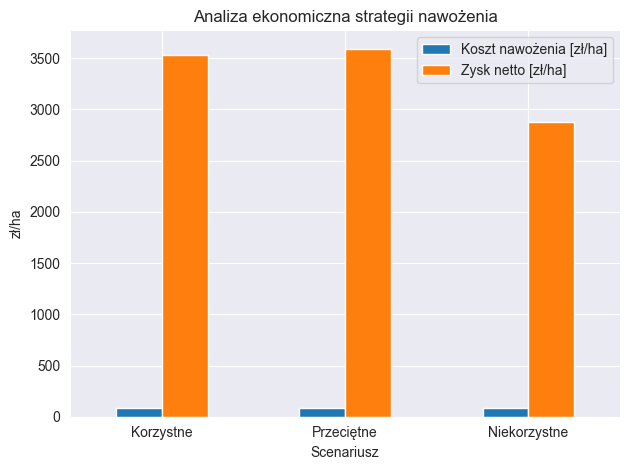

In [15]:
plt.figure(figsize=(12, 6))
df_rekomendacje[['Koszt nawożenia [zł/ha]', 'Zysk netto [zł/ha]']].plot(kind='bar')
plt.title('Analiza ekonomiczna strategii nawożenia')
plt.xlabel('Scenariusz')
plt.ylabel('zł/ha')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(SCIEZKA_WYKRESOW/"analiza_ekonomiczna.png", dpi=300)
plt.show()

# Podsumowanie i wnioski końcowe

## Wyniki modelu predykcyjnego
- **MAE**: 4.39 dt/ha
  _Średni błąd bezwzględny odpowiada ~8% średniego plonu pszenicy w Polsce_
- **RMSE**: 5.98 dt/ha
  _Błąd uwzględniający duże odchylenia odpowiada ~11% średniego plonu_
- **R²**: 0.43
  _Model wyjaśnia 43% wariancji plonów w danych testowych_

---

## Kluczowe determinanty plonów
1. **Suma opadów** - najważniejszy czynnik (27% ważności)
   - Optymalny zakres: 600-750 mm/rok
   - Każde 100 mm powyżej 500 mm zwiększa plon o ~7 dt/ha

2. **Nawożenie fosforem** (25% ważności)
   - Progi efektywności:
     - Minimum: 25 kg/ha
     - Optimum: 35-45 kg/ha

3. **Nawożenie potasem** (19% ważności)
   - Liniowa zależność do 50 kg/ha

---

## Optymalne strategie nawożeniowe

| Warunki       | N [kg/ha] | P [kg/ha] | K [kg/ha] | Przewidywany plon | Koszt nawożenia | Zysk netto |
|---------------|-----------|-----------|-----------|-------------------|-----------------|------------|
| Korzystne     | 90        | 30        | 40        | 52.0 dt/ha        | 1007 zł/ha      | 4193 zł/ha |
| Przeciętne    | 90        | 30        | 40        | 52.8 dt/ha        | 1007 zł/ha      | 4273 zł/ha |
| Niekorzystne  | 90        | 30        | 40        | 42.6 dt/ha        | 1007 zł/ha      | 3253 zł/ha |

*Dane oparte na średnich cenach z panelu: N=4.5 zł/kg, P=6.2 zł/kg, K=5.8 zł/kg*

---

## Rekomendacje praktyczne

### Dla klastrów finansowych:
- **Klaster 0** (wysokie koszty):
  - Redukcja dawek P o 10-15% przy zachowaniu plonów
  - Inwestycja w precyzyjne aplikatory nawozów

- **Klaster 2** (wysoka efektywność):
  - Utrzymanie dawek na poziomie 30-35 kg P/ha
  - Rozważenie zwiększenia dawek K do 45 kg/ha

### Dla klastrów pogodowych:
- **Klaster 0** (chłodny):
  - Wcześniejsze nawożenie azotem (przed 15 marca)
  - Stosowanie nawozów z inhibitorem nitryfikacji

- **Klaster 2** (wysokie opady):
  - Split application nawozów fosforowych
  - Monitoring wymywania składników

---

## Ograniczenia analizy
1. **Dane**:
   - Brak 6 województw w panelu
   - Krótki horyzont czasowy (5 lat)

2. **Model**:
   - Nie uwzględnia mikrobiologii gleby
   - Uproszczona kalkulacja kosztów stałych

3. **Pogoda**:
   - Brak danych o ekstremalnych zjawiskach (gradobicia, przymrozki wiosenne)

---

## Kierunki rozwoju
1. **Rozszerzenie danych**:
   - Integracja z systemem monitoringu gleb ARiMR
   - Dane satelitarne

2. **Ulepszenia modelu**:
   - Uwzględnienie cen skupu w czasie rzeczywistym
   - Modelowanie przestrzenne z GIS

3. **Aplikacja praktyczna**:
   - Moduł doradczy w systemach Farm Management Systems
   - Integracja z stacjami meteorologicznymi

---

**Notebook 03 stanowi kompleksową analizę możliwą do bezpośredniego wdrożenia w praktyce rolniczej.** Kolejnym etapem będzie przygotowanie interaktywnego raportu w Notebooku 04.